# 02 Driver Analysis
Identify the drivers behind win rates and pipeline quality using REM and RAPV with aging penalty.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

In [11]:
from pathlib import Path

PERCENT_SCALE = 100.0

def find_data_path() -> Path:
    roots = [Path.cwd().resolve(), Path.home(), Path("/workspaces"), Path("/home")]
    seen = set()
    for root in roots:
        if not root.exists() or root in seen:
            continue
        seen.add(root)
        for match in root.rglob("skygeni_sales_data.csv"):
            return match
    raise FileNotFoundError("Could not locate skygeni_sales_data.csv in common roots")

DATA_PATH = find_data_path()
print(f"Using data path: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df["created_date"] = pd.to_datetime(df["created_date"])
df["closed_date"] = pd.to_datetime(df["closed_date"])
df["is_won"] = (df["outcome"] == "Won").astype(int)
df["created_quarter"] = df["created_date"].dt.to_period("Q").astype(str)
df["closed_quarter"] = df["closed_date"].dt.to_period("Q").astype(str)

print(f"Rows: {len(df):,}")
print(df.head(3))

Using data path: /workspaces/skygeni-sales-intelligence/data/raw/skygeni_sales_data.csv
Rows: 5,000
  deal_id created_date closed_date sales_rep_id    industry         region  \
0  D00001   2023-11-24  2023-12-15       rep_22        SaaS  North America   
1  D00002   2023-01-17  2023-01-27        rep_7        SaaS          India   
2  D00003   2023-10-29  2023-12-10        rep_5  HealthTech           APAC   

  product_type lead_source deal_stage  deal_amount  sales_cycle_days outcome  \
0   Enterprise    Referral  Qualified         4253                21     Won   
1         Core    Referral     Closed         3905                10     Won   
2         Core     Inbound   Proposal        10615                42    Lost   

   is_won created_quarter closed_quarter  
0       1          2023Q4         2023Q4  
1       1          2023Q1         2023Q1  
2       0          2023Q4         2023Q4  


## Win/Loss Drivers Overview
Quick checks on numeric drivers and stage-level performance.

In [12]:
numeric_cols = ["deal_amount", "sales_cycle_days"]
corrs = df[numeric_cols].corrwith(df["is_won"]).sort_values(ascending=False)
corrs_df = corrs.reset_index()
corrs_df.columns = ["metric", "corr_with_win"]

print("Correlation with Win Outcome")
print(corrs_df.to_string(index=False))

stage_summary = (
    df.groupby("deal_stage", as_index=False)
    .agg(deals=("deal_id", "count"), win_rate=("is_won", "mean"))
    .sort_values("win_rate", ascending=False)
 )
stage_summary["win_rate_pct"] = (stage_summary["win_rate"] * PERCENT_SCALE).round(2)
print("\nWin Rate by Stage")
print(stage_summary[["deal_stage", "deals", "win_rate_pct"]].to_string(index=False))

Correlation with Win Outcome
          metric  corr_with_win
     deal_amount       0.016007
sales_cycle_days      -0.016075

Win Rate by Stage
 deal_stage  deals  win_rate_pct
     Closed    997         46.74
Negotiation    995         46.63
       Demo   1043         45.83
   Proposal   1009         44.70
  Qualified    956         42.26


## Segment Driver Analysis
Compare segment-level win rates, cycle times, and RAPV with aging penalty.

In [13]:
def segment_driver_summary(df_source: pd.DataFrame, segment_col: str) -> pd.DataFrame:
    """Summarize win rate, cycle time, and RAPV with aging penalty by segment."""
    stats = (
        df_source.groupby(segment_col, as_index=False)
        .agg(
            deals=("deal_id", "count"),
            win_rate=("is_won", "mean"),
            avg_deal_size=("deal_amount", "mean"),
            avg_cycle_days=("sales_cycle_days", "mean"),
            median_cycle=("sales_cycle_days", "median"),
        )
)
    stats["win_rate_pct"] = (stats["win_rate"] * PERCENT_SCALE).round(2)
    segment_map = stats.set_index(segment_col)["median_cycle"].to_dict()
    win_rate_map = stats.set_index(segment_col)["win_rate"].to_dict()

    df_local = df_source.copy()
    df_local["segment_median_cycle"] = df_local[segment_col].map(segment_map)
    df_local["segment_win_rate"] = df_local[segment_col].map(win_rate_map)
    cycle_denominator = df_local["sales_cycle_days"].replace(0, np.nan)
    df_local["aging_factor"] = (df_local["segment_median_cycle"] / cycle_denominator).clip(upper=1.0)
    df_local["aging_factor"] = df_local["aging_factor"].fillna(1.0)
    df_local["rapv_aging_value"] = (
        df_local["deal_amount"]
        * df_local["segment_win_rate"]
        * df_local["aging_factor"]
)
    rapv_summary = (
        df_local.groupby(segment_col, as_index=False)
        .agg(rapv_aging_value=("rapv_aging_value", "sum"))
)
    stats = stats.merge(rapv_summary, on=segment_col, how="left")
    stats["rapv_aging_value"] = stats["rapv_aging_value"].fillna(0.0)
    return stats.sort_values("rapv_aging_value", ascending=False)

segment_columns = ["industry", "product_type", "lead_source", "region"]
for segment in segment_columns:
    summary = segment_driver_summary(df, segment)
    print("\n" + "=" * 80)
    print(f"SEGMENT DRIVER: {segment.upper()}")
    print("=" * 80)
    print(summary[[segment, "deals", "win_rate_pct", "avg_cycle_days", "rapv_aging_value"]].head(5).to_string(index=False))
    print("\nBottom 5 by RAPV (aging):")
    print(summary[[segment, "deals", "win_rate_pct", "avg_cycle_days", "rapv_aging_value"]].tail(5).to_string(index=False))


SEGMENT DRIVER: INDUSTRY
  industry  deals  win_rate_pct  avg_cycle_days  rapv_aging_value
 Ecommerce   1060         44.91       63.918868      1.093723e+07
      SaaS   1001         45.15       64.619381      1.020861e+07
    EdTech    992         44.15       62.878024      1.009541e+07
   FinTech    937         47.71       63.869797      9.867994e+06
HealthTech   1010         44.55       63.465347      9.755434e+06

Bottom 5 by RAPV (aging):
  industry  deals  win_rate_pct  avg_cycle_days  rapv_aging_value
 Ecommerce   1060         44.91       63.918868      1.093723e+07
      SaaS   1001         45.15       64.619381      1.020861e+07
    EdTech    992         44.15       62.878024      1.009541e+07
   FinTech    937         47.71       63.869797      9.867994e+06
HealthTech   1010         44.55       63.465347      9.755434e+06

SEGMENT DRIVER: PRODUCT_TYPE
product_type  deals  win_rate_pct  avg_cycle_days  rapv_aging_value
         Pro   1676         45.29       63.810263      1.

## REM and RAPV Drivers
Summarize quarterly REM and RAPV trends using the updated metric definitions.

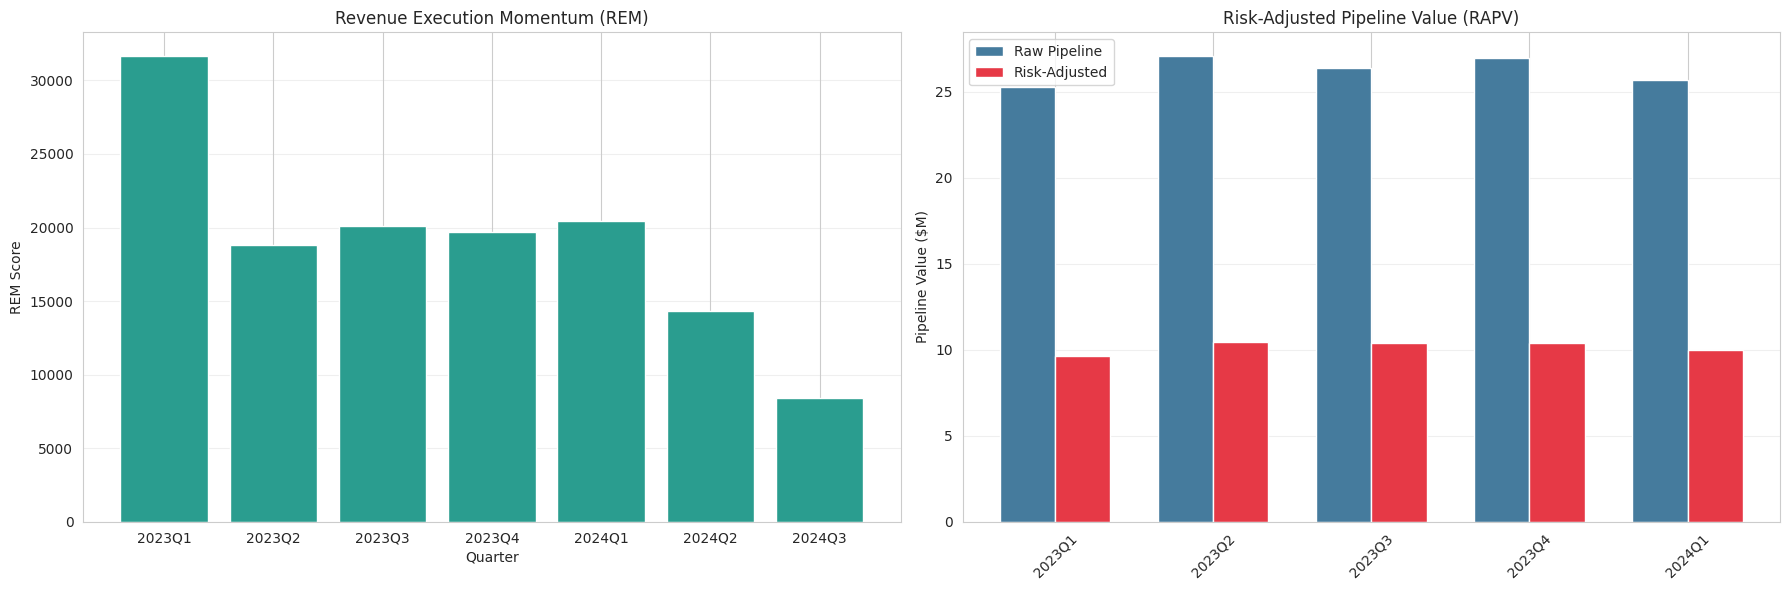

In [14]:
def calculate_rem_by_quarter(df_source: pd.DataFrame) -> pd.DataFrame:
    won_deals = df_source[df_source["is_won"] == 1].copy()
    rem_stats = (
        won_deals.groupby("closed_quarter", as_index=False)
        .agg(
            total_revenue=("deal_amount", "sum"),
            avg_cycle_days=("sales_cycle_days", "mean"),
            avg_deal_size=("deal_amount", "mean"),
            deals_won=("deal_id", "count"),
        )
)
    quarterly_totals = df_source.groupby("closed_quarter")["deal_id"].count()
    rem_stats["win_rate_pct"] = (
        rem_stats["deals_won"]
        / rem_stats["closed_quarter"].map(quarterly_totals)
        * PERCENT_SCALE
    )
    cycle_denominator = rem_stats["avg_cycle_days"].replace(0, np.nan)
    rem_stats["rem_score"] = (
        rem_stats["win_rate_pct"] * rem_stats["avg_deal_size"] / cycle_denominator
    )
    rem_stats["rem_score"] = rem_stats["rem_score"].fillna(0.0)
    rem_stats["quarter"] = rem_stats["closed_quarter"].astype(str)
    return rem_stats.sort_values("quarter")

def calculate_rapv_by_quarter(df_source: pd.DataFrame) -> pd.DataFrame:
    segment_columns = ["industry", "product_type", "lead_source", "region"]
    df_local = df_source.copy()
    for segment in segment_columns:
        win_rates = df_local.groupby(segment)["is_won"].mean()
        df_local[f"win_prob_{segment}"] = df_local[segment].map(win_rates)

    prob_columns = [f"win_prob_{seg}" for seg in segment_columns]
    df_local["blended_win_prob"] = df_local[prob_columns].mean(axis=1)

    segment_cycle_columns = []
    for segment in segment_columns:
        median_cycle = df_local.groupby(segment)["sales_cycle_days"].median()
        median_col = f"median_cycle_{segment}"
        df_local[median_col] = df_local[segment].map(median_cycle)
        segment_cycle_columns.append(median_col)

    overall_median_cycle = df_local["sales_cycle_days"].median()
    segment_median_cycle = df_local[segment_cycle_columns].mean(axis=1)
    segment_median_cycle = segment_median_cycle.fillna(overall_median_cycle)
    cycle_denominator = df_local["sales_cycle_days"].replace(0, np.nan)
    df_local["aging_factor"] = (segment_median_cycle / cycle_denominator).clip(upper=1.0)
    df_local["aging_factor"] = df_local["aging_factor"].fillna(1.0)

    df_local["risk_adjusted_value"] = (
        df_local["deal_amount"]
        * df_local["blended_win_prob"]
        * df_local["aging_factor"]
)
    rapv_by_quarter = (
        df_local.groupby("created_quarter", as_index=False)
        .agg(
            raw_pipeline=("deal_amount", "sum"),
            risk_adjusted_pipeline=("risk_adjusted_value", "sum"),
        )
)
    rapv_by_quarter["quarter"] = rapv_by_quarter["created_quarter"].astype(str)
    return rapv_by_quarter.sort_values("quarter")

quarterly_rem = calculate_rem_by_quarter(df)
rapv_by_quarter = calculate_rapv_by_quarter(df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.bar(quarterly_rem["quarter"], quarterly_rem["rem_score"], color="#2A9D8F")
ax1.set_title("Revenue Execution Momentum (REM)")
ax1.set_xlabel("Quarter")
ax1.set_ylabel("REM Score")
ax1.grid(True, axis="y", alpha=0.3)

raw = rapv_by_quarter["raw_pipeline"] / 1_000_000
adjusted = rapv_by_quarter["risk_adjusted_pipeline"] / 1_000_000
x_pos = np.arange(len(rapv_by_quarter))
width = 0.35
ax2.bar(x_pos - width / 2, raw, width, label="Raw Pipeline", color="#457B9D")
ax2.bar(x_pos + width / 2, adjusted, width, label="Risk-Adjusted", color="#E63946")
ax2.set_xticks(x_pos)
ax2.set_xticklabels(rapv_by_quarter["quarter"], rotation=45)
ax2.set_title("Risk-Adjusted Pipeline Value (RAPV)")
ax2.set_ylabel("Pipeline Value ($M)")
ax2.legend()
ax2.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Driver Takeaways
Quick narrative summary based on segment and quarterly metrics.

In [15]:
lead_source_summary = segment_driver_summary(df, "lead_source")
best_source = lead_source_summary.iloc[0]
worst_source = lead_source_summary.iloc[-1]
source_gap = best_source["win_rate_pct"] - worst_source["win_rate_pct"]

rem_latest = quarterly_rem["rem_score"].iloc[-1]
rem_prev = quarterly_rem["rem_score"].iloc[-2] if len(quarterly_rem) > 1 else np.nan
rem_change = rem_latest - rem_prev if not np.isnan(rem_prev) else np.nan

print("Driver Takeaways")
print("=" * 60)
print(f"Best lead source by RAPV: {best_source['lead_source']}")
print(f"Win rate gap vs worst source: {source_gap:.1f} pp")
if not np.isnan(rem_change):
    print(f"Latest REM change: {rem_change:+,.0f}")
print("RAPV shows material optimism gaps across most segments; prioritize aging deals in low-quality segments.")

Driver Takeaways
Best lead source by RAPV: Inbound
Win rate gap vs worst source: 2.1 pp
Latest REM change: -5,905
RAPV shows material optimism gaps across most segments; prioritize aging deals in low-quality segments.
